In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# 1. 데이터 경로 및 설정
# ----------------------------------------------------------------------
prefix_path = '/content/drive/MyDrive/UCI HAR Dataset/'
SENSOR_SIGNALS = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z'
]

TIME_STEPS = 128
NUM_FEATURES = 9
NUM_CLASSES = 6

In [67]:
# ----------------------------------------------------------------------
# 2. 데이터 로드 함수
# ----------------------------------------------------------------------
def load_raw_signal_data(phase, signals, path):
    X_data = []
    for signal_name in signals:
        filename = f'{path}{phase}/Inertial Signals/{signal_name}_{phase}.txt'
        signal_df = pd.read_csv(filename, delim_whitespace=True, header=None)
        X_data.append(signal_df.values)
    X_combined = np.stack(X_data, axis=2)
    return X_combined

def load_labels(phase, path):
    filename = f'{path}{phase}/y_{phase}.txt'
    y_data = pd.read_csv(filename, delim_whitespace=True, header=None).values.flatten() - 1
    y_one_hot = to_categorical(y_data, num_classes=NUM_CLASSES)
    return y_one_hot, y_data


In [68]:
# ----------------------------------------------------------------------
# 3. 데이터 로드
# ----------------------------------------------------------------------
print("--- 1. Raw Signal 데이터 로드 ---")
X_train_raw = load_raw_signal_data('train', SENSOR_SIGNALS, prefix_path)
y_train_one_hot, y_train_raw_flat = load_labels('train', prefix_path)
X_test_raw = load_raw_signal_data('test', SENSOR_SIGNALS, prefix_path)
y_test_one_hot, y_test_raw_flat = load_labels('test', prefix_path)

print(f"훈련 데이터 X 형태: {X_train_raw.shape}")
print(f"테스트 데이터 X 형태: {X_test_raw.shape}")


--- 1. Raw Signal 데이터 로드 ---


/tmp/ipython-input-352582388.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal_df = pd.read_csv(filename, delim_whitespace=True, header=None)
/tmp/ipython-input-352582388.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal_df = pd.read_csv(filename, delim_whitespace=True, header=None)
/tmp/ipython-input-352582388.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal_df = pd.read_csv(filename, delim_whitespace=True, header=None)
/tmp/ipython-input-352582388.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signal_df = pd.read_csv(filename, delim_whitespace=True, header=None)
/tmp

훈련 데이터 X 형태: (7352, 128, 9)
테스트 데이터 X 형태: (2947, 128, 9)


/tmp/ipython-input-352582388.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_data = pd.read_csv(filename, delim_whitespace=True, header=None).values.flatten() - 1


In [69]:
# ----------------------------------------------------------------------
# 4. 스케일링
# ----------------------------------------------------------------------
print("\n--- 2. 데이터 스케일링 (StandardScaler) ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, NUM_FEATURES)).reshape(X_train_raw.shape)
X_test_scaled = scaler.transform(X_test_raw.reshape(-1, NUM_FEATURES)).reshape(X_test_raw.shape)


--- 2. 데이터 스케일링 (StandardScaler) ---


In [70]:
# ----------------------------------------------------------------------
# 5. Data Augmentation (노이즈 추가)
# ----------------------------------------------------------------------
def augment_timeseries(X):
    noise = np.random.normal(0, 0.02, X.shape)
    X_noisy = X + noise
    return np.clip(X_noisy, -1, 1)

X_train_aug = augment_timeseries(X_train_scaled)
y_train_aug = y_train_one_hot.copy()

# 원본 + 증강 데이터 결합
X_train_total = np.concatenate([X_train_scaled, X_train_aug], axis=0)
y_train_total = np.concatenate([y_train_one_hot, y_train_aug], axis=0)

In [71]:
# ----------------------------------------------------------------------
# 6. 훈련/검증 데이터 분할
# ----------------------------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_train_total, y_train_total, test_size=0.2, random_state=42, stratify=np.tile(y_train_raw_flat, 2)
)

print("\n--- 3. 훈련/검증 데이터 분할 ---")
print(f"훈련 데이터 X 형태: {X_train.shape}")
print(f"검증 데이터 X 형태: {X_val.shape}")


--- 3. 훈련/검증 데이터 분할 ---
훈련 데이터 X 형태: (11763, 128, 9)
검증 데이터 X 형태: (2941, 128, 9)


In [72]:
# ----------------------------------------------------------------------
# 7. CNN + GRU 모델 정의
# ----------------------------------------------------------------------
def create_cnn_gru_model(timesteps, features, classes):
    model = Sequential()

    # CNN 블록 1
    model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=(timesteps, features)))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    # CNN 블록 2
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    # GRU
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.4))

    # Dense Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation='softmax'))

    # AdamW Optimizer 사용
    model.compile(
        loss='categorical_crossentropy',
        optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4),
        metrics=['accuracy']
    )
    return model

print("\n--- CNN + GRU 모델 정의 (개선 버전) ---")
gru_model = create_cnn_gru_model(TIME_STEPS, NUM_FEATURES, NUM_CLASSES)
gru_model.summary()


--- CNN + GRU 모델 정의 (개선 버전) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 128, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 128, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 64, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,974 (609.27 KB)

 Trainable params: 155,590 (607.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [73]:
# ----------------------------------------------------------------------
# 8. 콜백 설정
# ----------------------------------------------------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)


In [74]:
# ----------------------------------------------------------------------
# 9. 모델 훈련
# ----------------------------------------------------------------------
print("\n--- 모델 훈련 시작 ---")
history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[reduce_lr, early_stop]
)


--- 모델 훈련 시작 ---
Epoch 1/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5898 - loss: 0.9757 - val_accuracy: 0.7732 - val_loss: 0.5758 - learning_rate: 5.0000e-04
Epoch 2/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9275 - loss: 0.2005 - val_accuracy: 0.9527 - val_loss: 0.1313 - learning_rate: 5.0000e-04
Epoch 3/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9444 - loss: 0.1417 - val_accuracy: 0.9419 - val_loss: 0.1385 - learning_rate: 5.0000e-04
Epoch 4/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9475 - loss: 0.1281 - val_accuracy: 0.9541 - val_loss: 0.0996 - learning_rate: 5.0000e-04
Epoch 5/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9554 - loss: 0.1077 - val_accuracy: 0.9538 - val_loss: 0.0939 - learning_rate: 5.0000e-04
Epoch 6/100
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9544 - loss: 0.1053 - val_accuracy: 0.9578 - val_loss: 0.0977 - learning_rate: 5.0000e-04
Epoch 7/100
184/184 ━━━━━━━━━━━━━━

In [75]:
# ----------------------------------------------------------------------
# 10. 테스트 평가
# ----------------------------------------------------------------------
print("\n--- 모델 테스트 결과 ---")
loss, accuracy = gru_model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")



--- 모델 테스트 결과 ---
테스트 데이터 손실 (Loss): 0.3822
테스트 데이터 정확도 (Accuracy): 0.9484


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


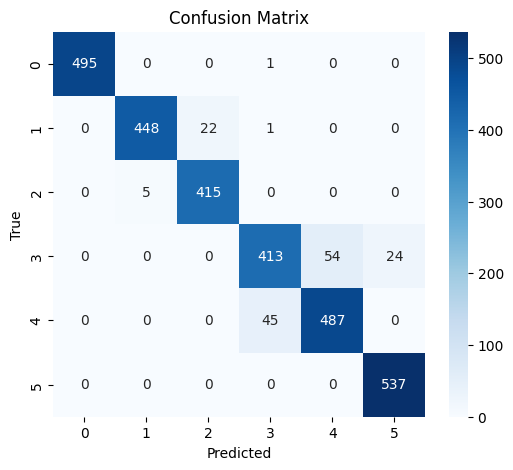


--- 분류 리포트 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       496
           1       0.99      0.95      0.97       471
           2       0.95      0.99      0.97       420
           3       0.90      0.84      0.87       491
           4       0.90      0.92      0.91       532
           5       0.96      1.00      0.98       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [76]:
# ----------------------------------------------------------------------
# 11. Confusion Matrix / Classification Report
# ----------------------------------------------------------------------
y_pred = np.argmax(gru_model.predict(X_test_scaled), axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\n--- 분류 리포트 ---")
print(classification_report(y_true, y_pred))